### Plot edge-encoding networks

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import numpy as np
import pandas as pd
import xarray as xr

from config import sessions
from tqdm import tqdm
from GDa.util import average_stages, _extract_roi

In [3]:
root = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/coherence")

In [4]:
t_coh_file = os.path.join(root, "tval_coh_avg_1_fdr.nc")
p_coh_file = os.path.join(root, "pval_coh_avg_1_fdr.nc")

In [5]:
t_coh = xr.load_dataarray(t_coh_file)
p_coh = xr.load_dataarray(p_coh_file)

t_coh = t_coh * (p_coh <= 0.01)

In [6]:
root_pow = "/home/vinicius/funcog/gda/Results/lucy/mutual_information/power"

In [7]:
# T-values
t_power = xr.load_dataarray(
    os.path.join(root_pow, "tval_pow_1_br_1_aligned_cue_avg_1_fdr.nc")
)

# p-values
p_power = xr.load_dataarray(
    os.path.join(root_pow, "pval_pow_1_br_1_aligned_cue_avg_1_fdr.nc")
)

In [8]:
t_power = t_power * (p_power <= 0.01)

In [9]:
TS = []
for session in tqdm(sessions):
    TS += [
        xr.load_dataarray(
            os.path.join(
                "/home/vinicius/funcog/gda/Results/lucy/meta_conn/",
                f"ts_coh_{session}_nothr.nc",
            )
        )
    ]
TS = xr.concat(TS, "roi").groupby("roi").mean("roi")

100%|████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 80.67it/s]


In [10]:
_FILE_NAME = "power_tt_1_br_1_at_cue.nc"
_FILE_NAME_DEGREE = "coh_degree_at_cue.nc"


def return_file_path(_ROOT, _FILE_NAME, s_id, net=False):
    if net:
        path_metric = os.path.join(
            _ROOT, f"Results/lucy/{s_id}/session01/network", _FILE_NAME
        )
    else:
        path_metric = os.path.join(_ROOT, f"Results/lucy/{s_id}/session01", _FILE_NAME)
    return path_metric


def load_sessions(_ROOT, _FILE_NAME, net=False):
    """Load data for all sessions"""

    data = []
    for s_id in tqdm(sessions):
        # Get path to file
        path_metric = return_file_path(_ROOT, _FILE_NAME, s_id, net=net)
        # Load network feature
        out = xr.load_dataarray(path_metric)
        # Average if needed
        out = average_stages(out, 1)
        # Concqtenate channels
        data += [
            out.isel(roi=[r]).astype(np.float32).mean("trials")
            for r in range(len(out["roi"]))
        ]

    # Concatenate channels
    data = xr.concat(data, dim="roi")
    # Get unique rois
    urois, counts = np.unique(data.roi.data, return_counts=True)
    # Get unique rois that has at leats 10 channels
    urois = urois[counts >= 10]
    # Average channels withn the same roi
    data = data.groupby("roi").mean("roi", skipna=True)
    data = data.sel(roi=urois)
    return data

In [11]:
_ROOT = os.path.expanduser("~/funcog/gda/")
power = load_sessions(_ROOT, _FILE_NAME)

100%|████████████████████████████████████████████████████████| 62/62 [02:11<00:00,  2.12s/it]


In [12]:
TS = TS.sel(roi=power.roi.values)

In [13]:
t_coh.to_dataframe("t_coh").reset_index().to_csv("data/t_coh.csv")
TS.to_dataframe("TS").reset_index().to_csv("data/TS.csv")
power.to_dataframe("power").reset_index().to_csv("data/power.csv")
t_power.to_dataframe("t_power").reset_index().to_csv("data/t_power.csv")

In [14]:
out = (t_coh > 0).sum("roi")

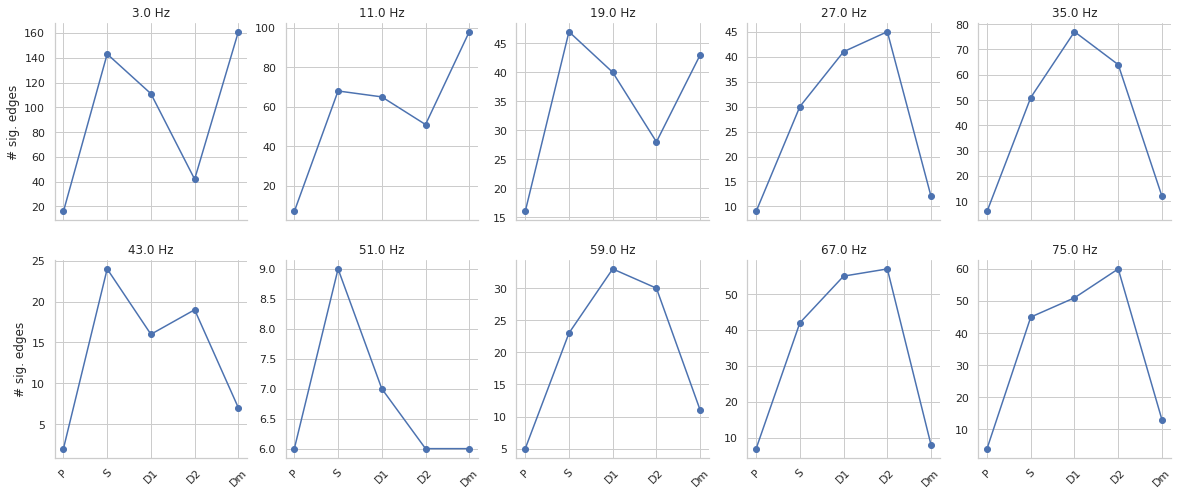

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(out.isel(freqs=i), "o-")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i < 5:
        plt.xticks(range(5), ["", "", "", "", ""])
    else:
        plt.xticks(range(5), ["P", "S", "D1", "D2", "Dm"], rotation=45)
    if i == 0 or i == 5:
        plt.ylabel("# sig. edges")
    plt.title(f"{out.freqs.values[i]} Hz")

In [16]:
path_to_nli = "/home/vinicius/funcog/gda/Results/lucy/nli/"
nli = []
mean_coh = []

for session in tqdm(sessions):

    nli += [xr.load_dataarray(os.path.join(path_to_nli, f"nli_coh_{session}.nc"))]
    mean_coh += [
        xr.load_dataarray(os.path.join(path_to_nli, f"mean_coh_coh_{session}.nc"))
    ]

nli = xr.concat(nli, "roi").groupby("roi").mean("roi")
mean_coh = xr.concat(mean_coh, "roi").groupby("roi").mean("roi")

100%|████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 67.13it/s]


In [17]:
rois = nli.roi.values

In [18]:
roi_s, roi_t = _extract_roi(rois, "-")
unique_rois = np.unique(np.hstack((roi_s, roi_t)))
_iter = range(len(unique_rois))
label_to_idx = dict(zip(unique_rois, _iter))

In [28]:
nli_mat = np.zeros((len(unique_rois), len(unique_rois), 10))

In [29]:
for i, (s, t) in enumerate(zip(roi_s, roi_t)):
    
    i_s, i_t = label_to_idx[s], label_to_idx[t]
    
    nli_mat[i_s, i_t, :] = nli_mat[i_t, i_s, :] = nli[i, :]

In [31]:
nli_deg = xr.DataArray(nli_mat.sum(1), dims=("roi", "freqs"), coords=(unique_rois, nli.freqs.values))

In [33]:
nli_deg = nli_deg.sel(roi=power.roi)

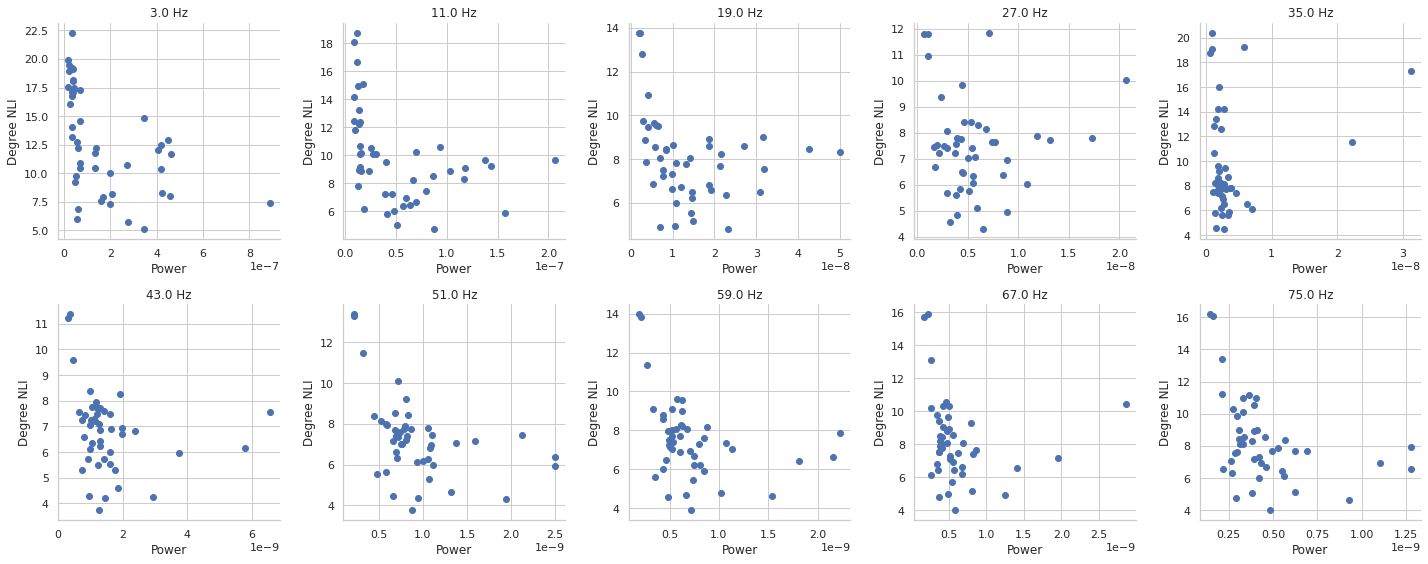

In [39]:
plt.figure(figsize=(20, 8))
for i in range(10):

    ax = plt.subplot(2, 5, i + 1)
    plt.plot(power.mean("times").isel(freqs=i), nli_deg.isel(freqs=i), "o")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylabel("Degree NLI")
    plt.xlabel("Power")
    plt.title(f"{out.freqs.values[i]} Hz")
plt.tight_layout()

In [1]:
# Libraries
library(ggraph)
library(ggpubr)
library(igraph)
library(tidyverse)
library(repr)
library(RColorBrewer)

Loading required package: ggplot2


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ──────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ─────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()



#### Loading data

In [63]:
root = "/home/vinicius/funcog/gda" 
results = "/home/vinicius/storage1/projects/GrayData-Analysis/figures/edge_encoding"

t_coh = read.csv("data/t_coh.csv")
t_power = read.csv("data/t_power.csv")
power = read.csv("data/power.csv")
TS = read.csv("data/TS.csv") 

In [64]:
names <- unlist( strsplit(t_coh$roi, "-", fixed=T) )
count <- 1
sources <- NULL
targets <- NULL

for(i in 1:nrow(t_coh)) {
  sources[i] <- names[count]
  count <- count + 1
  targets[i] <- names[count]
  count <- count + 1
}

t_coh$s <- sources
t_coh$t <- targets

In [84]:
f <- 35
t <- 3

metric <- "t_coh"
metric_node <- "t_power"
title <- F

df <- t_coh
df_nodes <- t_power

idx = (df$freqs == f) & (df$times == t)
df_filt <- df[idx, ]

idx_p = (df_nodes$freqs == f) & (df_nodes$times == t)
df_nodes_filt <- df_nodes[idx_p, ]

# Store t_values
t_values <- unlist(df_filt[metric])
t_values <- mean(t_values)
# Binary network
weights <- unlist(df_filt[metric])
# Creating network
edges <- df_filt %>% select(6:7)
edges$weights <- weights
edges <- edges %>% rename(from = s, to = t)

edges <- edges[order(edges$from),]

rois <- unique(c(as.character(edges$from), as.character(edges$to)))
n_rois <- length(rois)
n_pairs <- length(weights)

# Getting power t-values for each ROI
node_size <- rep(0, n_rois)
i <- 1
for(roi in rois) {
    if(roi %in% df_nodes_filt$roi) {
      node_size[i] <- df_nodes_filt[df_nodes_filt$roi==roi, ][, metric_node]
    } else {
      node_size[i] <- 0
    }
    i <- i + 1
}
node_size <- ( node_size / max(node_size) ) ^ 2

nodes <- as.data.frame(rois)
nodes <- nodes %>% rename(id = rois)

# Create a graph object
graph <- igraph::graph_from_data_frame( d=edges, vertices=nodes, directed=F )

if(title == T) {
if(t == 0) {
  title <- "P"
} else if(t == 1) {
  title <- "S"
} else if(t == 2) {
  title <- "D1"
} else if(t == 3) {
  title <- "D2"
} else {
  title <- "Dm"
}
} else {
title <- ""
}

if(t==0) {
ylabel <- paste(c(f, "Hz"),
                collapse=" ") 
} else {
ylabel <- " "
}

filter <- (edges$weights>0) 
    
  p <- ggraph(graph, layout = 'linear', circular = TRUE) + 
geom_edge_arc(aes(filter = filter,
                  width = edges$weights,
                  color = edges$weights),
              show.legend=F) +
scale_edge_color_continuous(low = "white", high = "blue",
                            na.value="blue", limits = c(0, 10)) +
scale_edge_width_continuous(range = c(0,3), limits = c(0, 10)) +
geom_node_point(aes(x = x*1.07, y=y*1.07,color=node_size+1e-10),
                size=10 * node_size,
                alpha=0.6, show.legend=F) +
geom_node_text(aes(label=rois, x=x*1.15, y=y*1.15),
               color="black",
               size=4, alpha=1, show.legend=F) +
theme_void() +
ggtitle(title) +
ylab(ylabel) +
theme(
  plot.title = element_text(hjust = 0.5, size=10),
  plot.margin=unit(c(0,0,0,0),"cm"),
    )

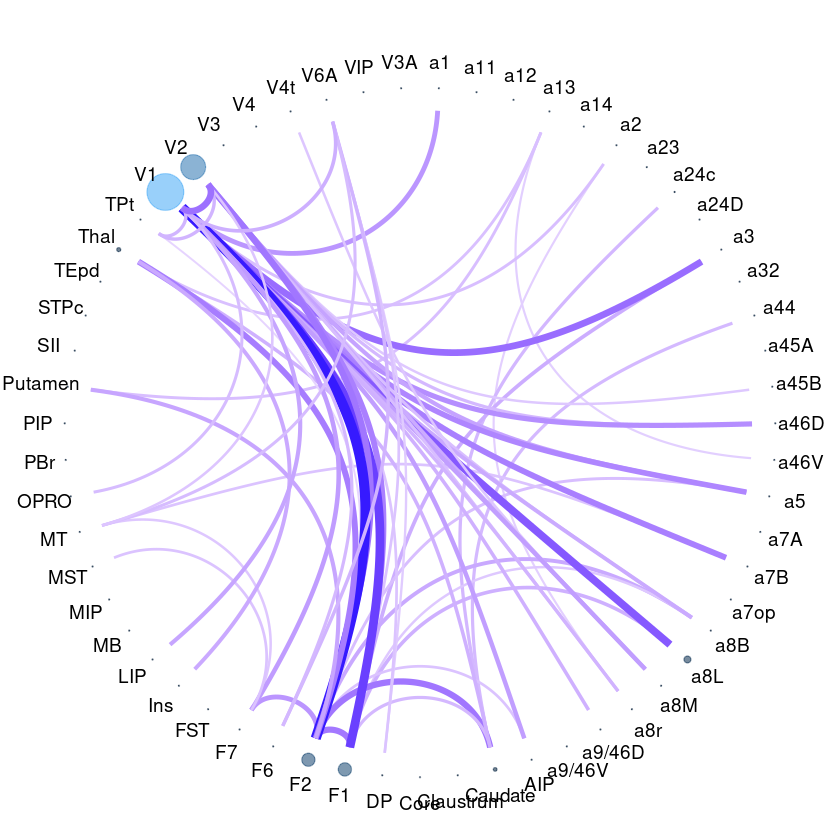

In [85]:
p

In [100]:
create_graph <- function(df, df_nodes, f, t, metric, metric_node, title) {

    idx = (df$freqs == f) & (df$times == t)
    df_filt <- df[idx, ]

    idx_p = (df_nodes$freqs == f) & (df_nodes$times == t)
    df_nodes_filt <- df_nodes[idx_p, ]

    # Store t_values
    t_values <- unlist(df_filt[metric])
    t_values <- mean(t_values)
    # Binary network
    weights <- unlist(df_filt[metric])
    # Creating network
    edges <- df_filt %>% select(6:7)
    edges$weights <- weights
    edges <- edges %>% rename(from = s, to = t)

    edges <- edges[order(edges$from),]

    # Getting power t-values for each ROI
    node_size <- rep(0, n_rois)
    i <- 1
    for(roi in rois) {
        if(roi %in% df_nodes_filt$roi) {
          node_size[i] <- df_nodes_filt[df_nodes_filt$roi==roi, ][, metric_node]
        } else {
          node_size[i] <- 0
        }
        i <- i + 1
    }
    node_size <- ( node_size / max(node_size) ) ^ 2

    nodes <- as.data.frame(rois)
    nodes <- nodes %>% rename(id = rois)

    # Create a graph object
    graph <- igraph::graph_from_data_frame( d=edges, directed=F )
    
    rois <- V(graph)$name
    n_rois <- length(rois)
    n_pairs <- length(weights)

    if(title == T) {
    if(t == 0) {
      title <- "P"
    } else if(t == 1) {
      title <- "S"
    } else if(t == 2) {
      title <- "D1"
    } else if(t == 3) {
      title <- "D2"
    } else {
      title <- "Dm"
    }
    } else {
    title <- ""
    }

    if(t==0) {
    ylabel <- paste(c(f, "Hz"),
                    collapse=" ") 
    } else {
    ylabel <- " "
    }

    filter <- (edges$weights>0) 

    p <- ggraph(graph, layout = 'linear', circular = TRUE) + 
    geom_edge_arc(aes(filter = filter,
                      width = edges$weights,
                      color = edges$weights),
                  show.legend=F) +
    scale_edge_color_continuous(low = "white", high = "blue",
                                na.value="blue", limits = c(0, 10)) +
    scale_edge_width_continuous(range = c(0,3), limits = c(0, 10)) +
    geom_node_point(aes(x = x*1.07, y=y*1.07,color=node_size+1e-10),
                    size=15 * node_size,
                    alpha=0.6, show.legend=F) +
    geom_node_text(aes(label=rois, x=x*1.15, y=y*1.15),
                   color="black",
                   size=4, alpha=1, show.legend=F) +
    theme_void() +
    ggtitle(title) +
    ylab(ylabel) +
    theme(
      plot.title = element_text(hjust = 0.5, size=10),
      plot.margin=unit(c(0,0,0,0),"cm"),
        )
  return(p)
}

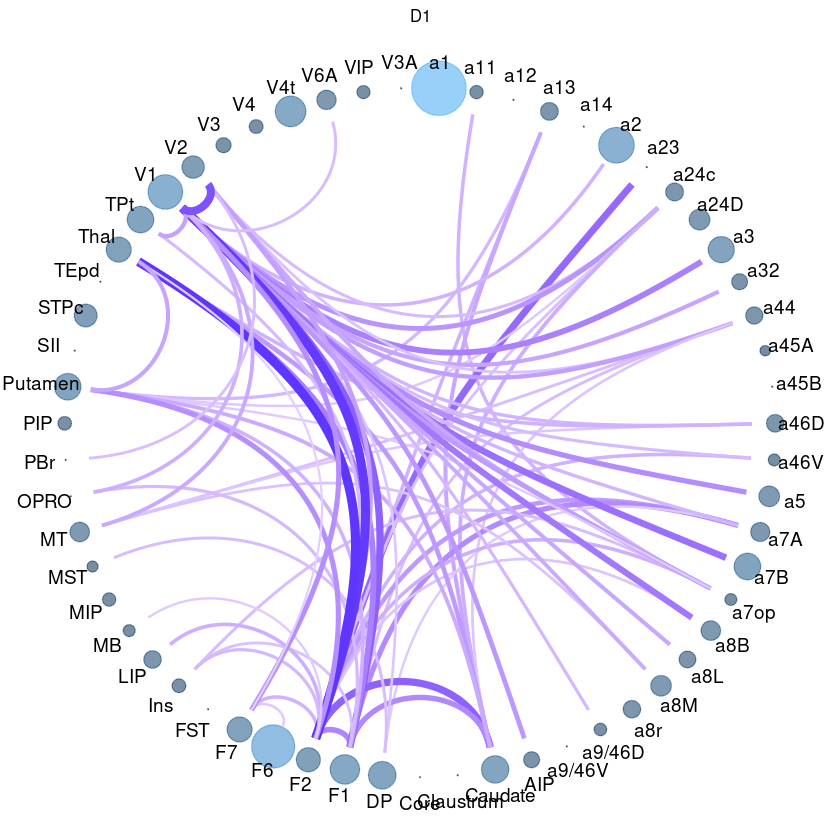

In [101]:
create_graph(t_coh, TS, 35, 2, "t_coh", "TS", T)

#### Encoding networks + power encoding

In [25]:
p <- create_graph(t_coh, t_power, 35., 3, "t_coh", "t_power", "")

ERROR: Error in node_size/2: non-numeric argument to binary operator


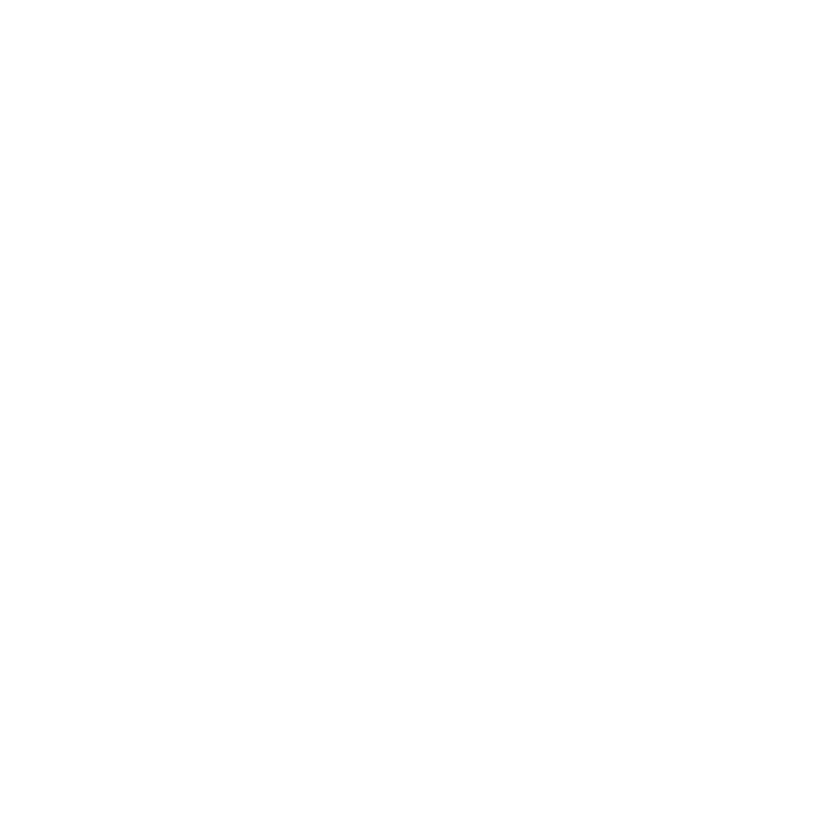

In [23]:
p

In [ ]:
count <- 1
for(f in freqs) {
  myplots <- vector('list', length(times) * 2)
  i <- 1
  for(t in 0:4) {
    p1 <- create_graph(f, t, "coh", T)
    myplots[[i]] <- local({
      i <- i
      print(p1)
    })
    i <- i + 1
  }
  
  for(t in 0:4) {
    p1 <- create_graph(f, t, "plv", F)
    myplots[[i]] <- local({
      i <- i
      print(p1)
    })
    i <- i + 1
  }
  
  plot <- ggarrange(plotlist=myplots,
                    ncol =length(times), nrow = 2,
                    labels = c("A", " ", " ", " ", " ",
                               "B", " ", " ", " ", " ")) 
  
  title <- paste(c("Enconding netoworks, band ", count), collapse = "")
  annotate_figure(plot, top = text_grob(title, 
                                        color = "black", face = "bold", size = 14))
  
  ggsave(
    paste(
      c(results,
        "/mi_edge_power_encoding_", count,".png"),
      collapse = ""),
    width = 18, height = 6)
  
  count <- count + 1 
}

ERROR: Error in df$freqs: object of type 'closure' is not subsettable


#### Encoding networks + trimmer strengths

In [14]:
# Load trimmer-strengths encoding
TS <- read.csv(
  paste(
    c(root, "/Results/lucy/meta_conn/ts_coh.csv"),
    collapse = "")
)[, 2:5]

create_graph <- function(f, t, metric, title) {
  # Load data
  df = read.csv(
    paste(
      c(root,
        "/Results/lucy/mutual_information/mi_",
        metric,
        "_fdr.csv"),
      collapse="")
  )
  
  # Filter frequency and time of interest
  idx = (df$freqs == f) & (df$times == t)
  df_filt <- df[idx, ]
  # Filter trimmer-strengts for time and freq
  idx_p = (TS$freqs == f) & (TS$times == t)
  ts_filt <- TS[idx_p, ]
  
  # Get weights
  weights <- unlist(df_filt[metric])
  # Creating network
  edges <- df_filt %>% select(6:7)
  edges$weights <- weights
  edges <- edges %>% 
    rename(from = s,
           to = t)
  
  edges <- edges[order(edges$from),]
  
  rois <- unique(c(as.character(edges$from), as.character(edges$to)))
  n_rois <- length(rois)
  n_pairs <- length(weights)
  
  # Getting trimme-strength for each ROI
  ts_t <- rep(0, length(rois))
  i <- 1
  for(roi in rois) {
    if(roi %in% ts_filt$roi) {
      ts_t[i] <- ts_filt[ts_filt$roi==roi, ]$ts
    } else {
      ts_t[i] <- 0
    }
    i <- i + 1
  }
  
  nodes <- as.data.frame(rois)
  nodes <- nodes %>% rename(id = rois)
  
  # Create a graph object
  graph <- igraph::graph_from_data_frame( d=edges, vertices=nodes, directed=F )
  
  strengths <- igraph::strength(graph = graph, weights = edges$weights)
  
  if(title == TRUE) {
    if(t == 0) {
      title <- "P"
    } else if(t == 1) {
      title <- "S"
    } else if(t == 2) {
      title <- "D1"
    } else if(t == 3) {
      title <- "D2"
    } else {
      title <- "Dm"
    }
  } else {
    title <- ""
  }
  
  if(t==0) {
    ylabel <- paste(c(f, "Hz"),
                    collapse=" ") 
  } else {
    ylabel <- " "
  }
  
  filter <- (edges$weights>0) 
      
  ts_t <- ( ts_t / max(ts_t) ) ^ 2
  
  p <- ggraph(graph, layout = 'linear', circular = TRUE) + 
    geom_edge_arc(aes(filter = filter,
                      width = edges$weights,
                      color = edges$weights),
                  show.legend=F) +
    scale_edge_color_continuous(low = "white", high = "blue",
                                na.value="blue", limits = c(0, 10)) +
    scale_edge_width_continuous(range = c(0,3), limits = c(0, 10)) +
    geom_node_point(aes(x = x*1.07, y=y*1.07),
                    size=10 * ts_t, color="blue",
                    alpha=0.6, show.legend=F) +
    geom_node_text(aes(label=rois, x=x*1.15, y=y*1.15),
                   color="black",
                   size=2, alpha=1, show.legend=F) +
    theme_void() +
    ggtitle(title) +
    ylab(ylabel) +
    theme(
      plot.title = element_text(hjust = 0.5, size=10),
      plot.margin=unit(c(0,0,0,0),"cm"),
    ) 
  return(p)
}

In [ ]:
count <- 1
for(f in freqs) {
  myplots <- vector('list', length(times) * 2)
  i <- 1
  for(t in 0:4) {
    p1 <- create_graph(f, t, "coh", T)
    myplots[[i]] <- local({
      i <- i
      print(p1)
    })
    i <- i + 1
  }
  
  for(t in 0:4) {
    p1 <- create_graph(f, t, "plv", F)
    myplots[[i]] <- local({
      i <- i
      print(p1)
    })
    i <- i + 1
  }
  
  plot <- ggarrange(plotlist=myplots,
                    ncol =length(times), nrow = 2,
                    labels = c("A", " ", " ", " ", " ",
                               "B", " ", " ", " ", " ")) 
  
  title <- paste(c("Enconding netoworks, band ", count), collapse = "")
  annotate_figure(plot, top = text_grob(title, 
                                        color = "black", face = "bold", size = 14))
  
  ggsave(
    paste(
      c(results,
        "/mi_edge_trimmer_encoding_", count,".png"),
      collapse = ""),
    width = 18, height = 6)
  
  count <- count + 1 
}

#### Trimmer-strength distributions

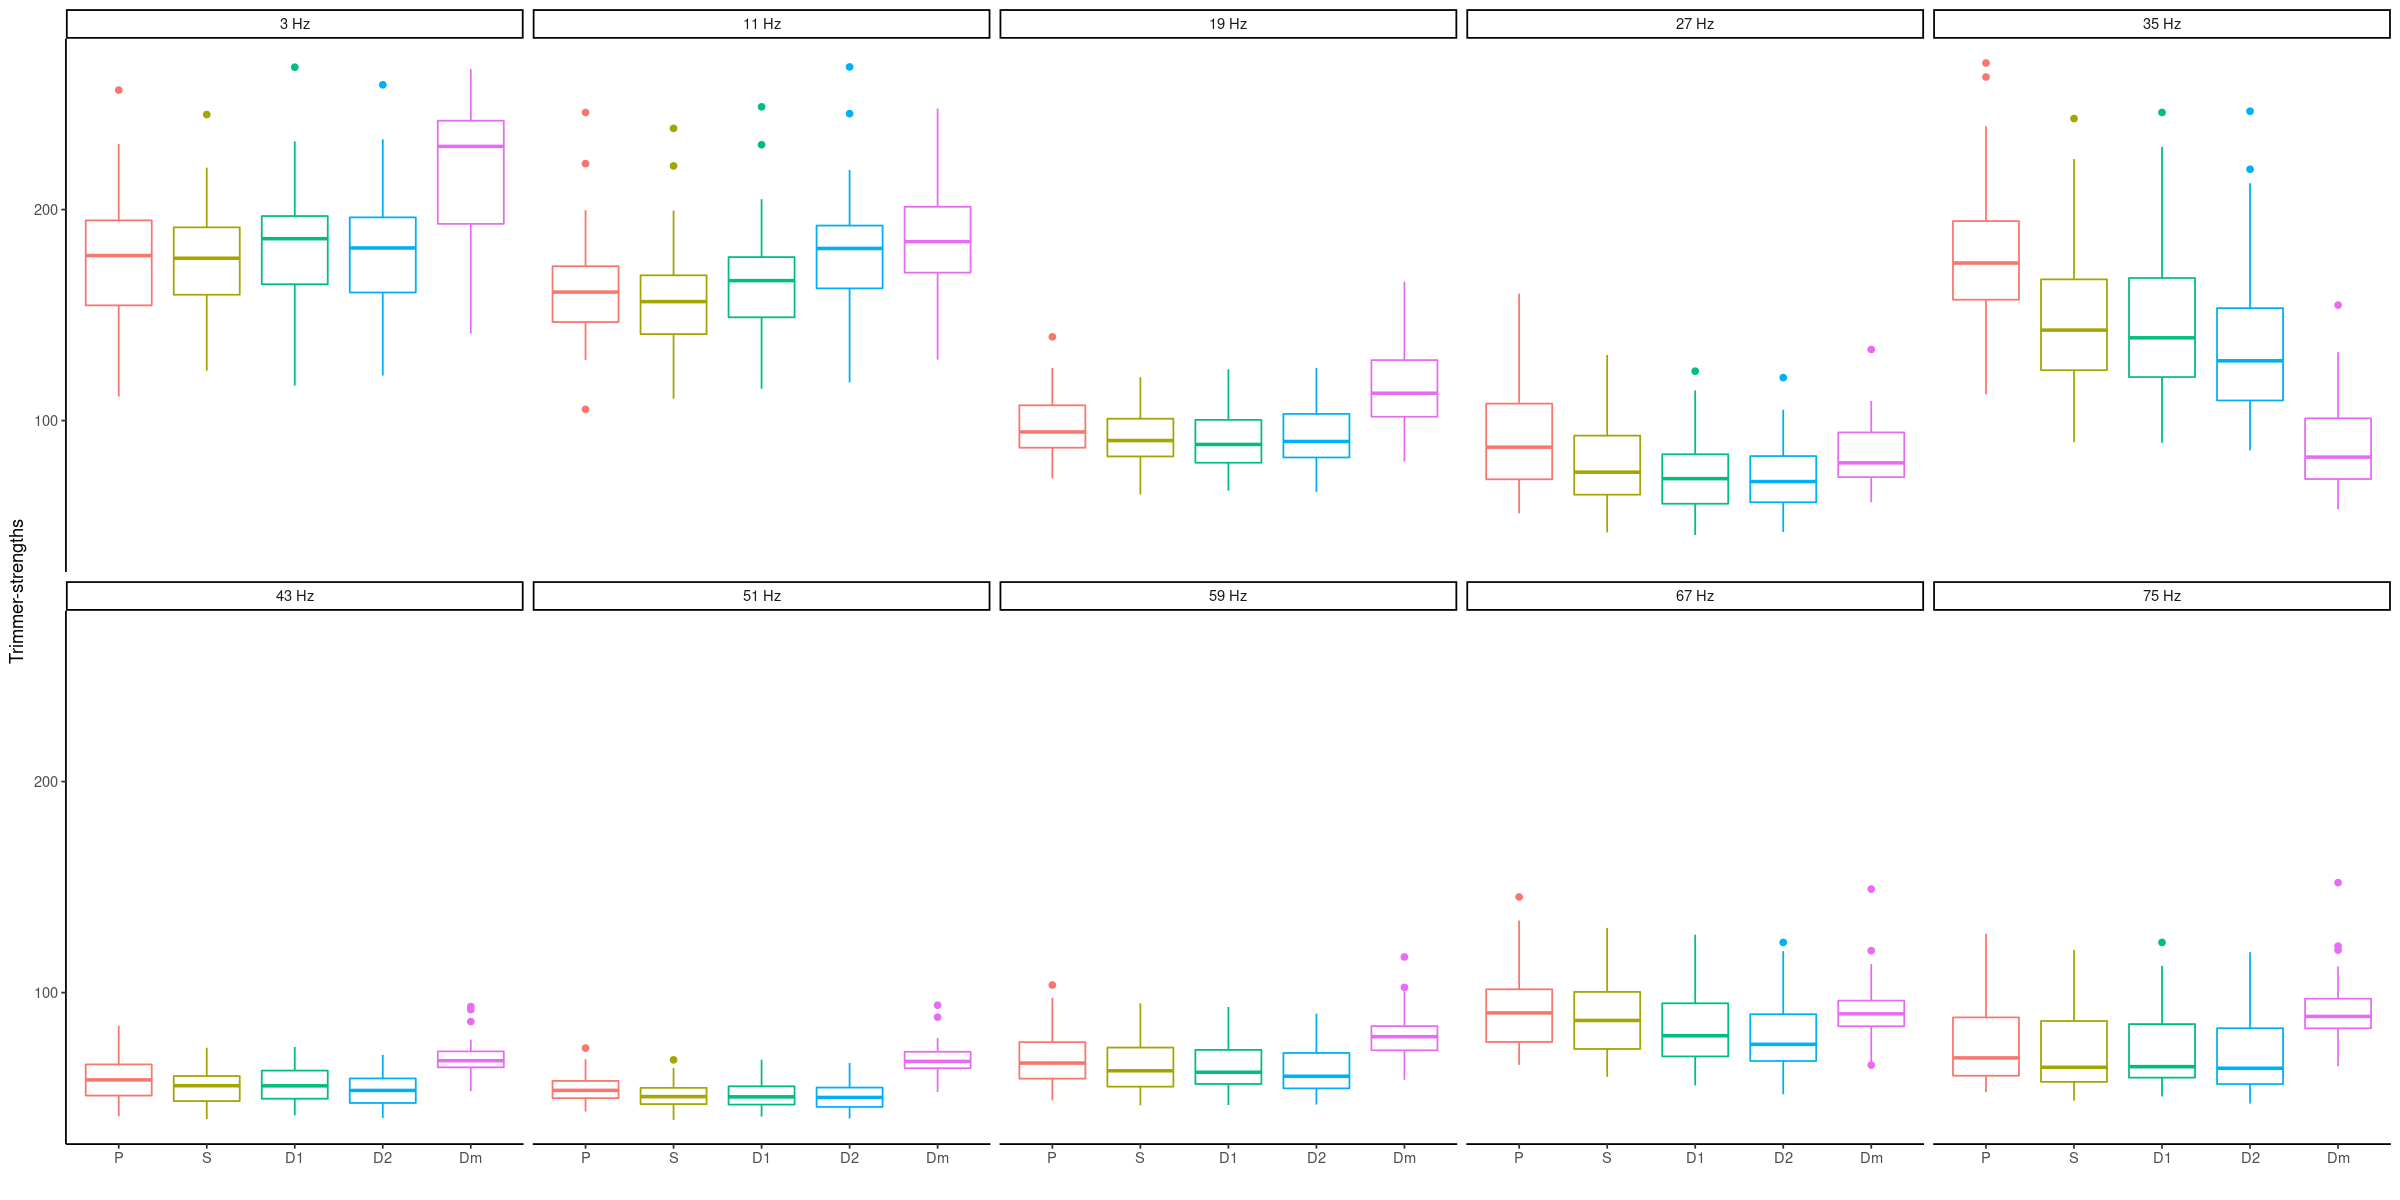

In [16]:
# Define labels
freqs.labs <- c("3 Hz", "11 Hz", "19 Hz", "27 Hz", "35 Hz",
                "43 Hz", "51 Hz", "59 Hz", "67 Hz", "75 Hz")
names(freqs.labs) <- as.character(unique(neff$freqs))

times.labs <- c("P", "S", "D1", "D2", "Dm")
names(times.labs) <- 0:4

TS <- read.csv(
  paste(
    c(root, "/Results/lucy/meta_conn/ts_coh.csv"),
    collapse = "")
)[, 2:5]

options(repr.plot.width=20, repr.plot.height=10)
TS %>% ggplot(aes(x=as.factor(times), y=ts, color = as.factor(times))) + 
       geom_boxplot() +
       scale_x_discrete(labels=times.labs) +
       facet_wrap(~freqs, ncol=5, 
                  labeller = labeller(freqs = freqs.labs)) +
       labs(x = "", y = "Trimmer-strengths") + 
       theme_classic() +
       theme(legend.position = "none")